# Viscoelasticity

**This is really cool. There's a simple boundary integral equation for layered linear viscoelasticity. I started working through the math thinking that I'd need to handle a volumetric term, but then I realized that the volumetric term reduces to just a boundary integral for the special case of layered viscoelasticity.**

## A layered viscoelastic PDE
Let's start from the constitutive equation for a Maxwell viscoelastic rheology in antiplane strain:

\begin{align}
\dot{\vec{\sigma}} &= 2\mu\dot{\vec{\epsilon}} - \frac{\mu}{\eta}\vec{\sigma}
\end{align}

where $\vec{\sigma} = (\sigma_{xz}, \sigma_{yz})$ is the vector stress in the antiplane setting, $\mu$ is the shear modulus and $\eta$ is the viscosity.

And the definition of strain, again in the antiplane setting:
\begin{equation}
\vec{\epsilon} = \frac{1}{2}\nabla u
\end{equation}

And Newton's law making a quasistatic assumption that the momentum term is negligible:
\begin{equation}
\nabla \cdot \vec{\sigma} = 0
\end{equation}

Inserting the Maxwell constitutive equation into the time derivative of Newton's law and then applying the definition of strain, we get:
\begin{align}
\nabla \cdot (2\mu\dot{\vec{\epsilon}} - \frac{\mu}{\eta}\vec{\sigma}) = 0\\
2\mu \nabla^2 \dot{u} = \nabla \cdot (\frac{\mu}{\eta}\vec{\sigma})
\end{align}

Let's explore that right hand side a bit more. If we apply the product rule, we get one term that depends on the gradient of the material properties and another term that depends on the divergence of stress. However we've already assumed that the divergence of stress is zero so that term drops out. 
\begin{align}
\nabla \cdot (\frac{\mu}{\eta}\vec{\sigma}) &= \nabla (\frac{\mu}{\eta}) \cdot \vec{\sigma} + \frac{\mu}{\eta} (\nabla \cdot \vec{\sigma})\\
&= \nabla (\frac{\mu}{\eta}) \cdot \vec{\sigma}
\end{align}


Conceptually, this is pretty interesting and tells us that viscosity only influences the displacement solution through its spatial variation. Critically for us, in a layered halfspace model, that spatial variation only occurs on a single or small number of surfaces separating the layers. 

Consider the figure below: a classic layered Maxwell viscoelastic half space where $\mu$ is constant and $\eta$ varies only as a step function across the elastic/viscoelastic boundary. As a result, the term that includes a viscosity divergence will simplify to:
\begin{equation}
\nabla (\frac{\mu}{\eta}) = (0, -\delta(y=D) \frac{\mu}{\eta_V})
\end{equation}

The negative is because inverse viscosity decreases in the positive y direction.

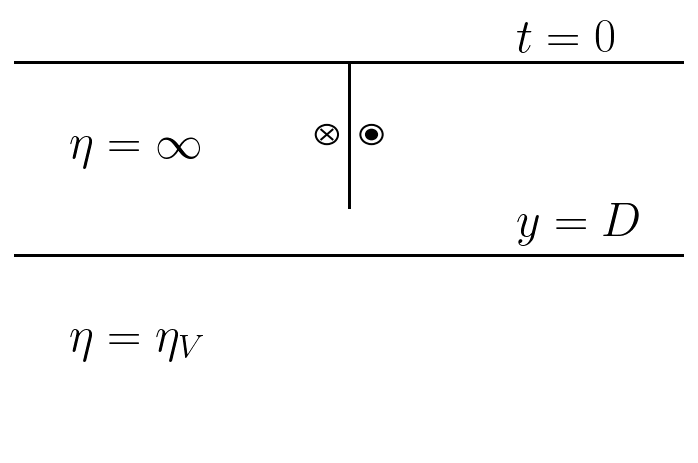

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["text.usetex"] = True
%config InlineBackend.figure_format='retina'

x = np.linspace(-1, 1, 100)
plt.plot(3 * x, 0 * x, "k-")
plt.plot(3 * x, -2 + 0 * x, "k-")
plt.plot(0 * x, -0.75 + 0.75 * x, "k-")
plt.text(-2.5, -1, "$\\eta = \\infty$", fontsize=24)
plt.text(-2.5, -3, "$\\eta = \\eta_V$", fontsize=24)
plt.text(1.5, 0.1, "$t = 0$", fontsize=24)
plt.text(1.5, -1.8, "$y = D$", fontsize=24)


plt.gca().add_patch(plt.Circle((0.2, -0.75), 0.10, color="k", fill=False))
plt.gca().add_patch(plt.Circle((0.2, -0.75), 0.05, color="k", fill=True))
plt.gca().add_patch(plt.Circle((-0.2, -0.75), 0.10, color="k", fill=False))
plt.plot([-0.25, -0.15], [-0.8, -0.7], "k-", linewidth=1)
plt.plot([-0.15, -0.25], [-0.8, -0.7], "k-", linewidth=1)

plt.xlim([-3, 3])
plt.ylim([-4, 0.5])
plt.axis("off")
plt.savefig("layered_ve.pdf")
plt.show()

So, the final equation we'd like to solve is:
\begin{equation}
2\mu \nabla^2 \frac{\partial u}{\partial t} = -\delta(y=D) \frac{\mu}{\eta_V} \sigma_y 
\end{equation}

In some situations, it can be more convenient to consider the equation in terms of the displacement rather than the velocity:
\begin{equation}
2\mu \nabla^2 u = -\delta(y=D) \frac{\mu}{\eta_V} \int_{0}^{T} \sigma_y dt
\end{equation}

Now, how do we solve this? The key is relate this equation back to the governing PDE for linear elasticity with a body force term:
\begin{equation}
2\mu\nabla^2u = f
\end{equation}

The two equations take the same form if we assign:
\begin{equation}
f = -\delta(y=D) \frac{\mu}{\eta_V} \int_{0}^{T} \sigma_y dt
\end{equation}

So, any numerical method that can solve linear elastic problems with a body force can, with appropriate care, solve our layered viscoelastic problem.

## Viscoelastic boundary integral equation

So, now that we've developed this layered viscoelastic PDE, lets' transform it into integral form! Applying Somigliana's identity to the linear elastic problem with an arbitrary body force on our geometry, we get:

\begin{equation}
u(\mathbf{p}) = -\int_{H} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) u(\mathbf{q}) d\mathbf{q} -\int_{F} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) s(\mathbf{q}) d\mathbf{q} + \int_{\Omega} G(\mathbf{p},\mathbf{q}) f(\mathbf{q}) d\mathbf{q}
\end{equation}
where $\mathbf{p}$ is the observation point, $u$ is the displacement, $s$ is the slip on the fault, $H$ is the free surface, $F$ is the fault surface, $\Omega$ is the whole domain, $G$ is the fundamental solution of the Laplace equation, $\frac{\partial G}{\partial n_q}$ is the kernel of the double layer potential. 

First off, this is *not* a boundary integral equation. There is a volumetric integral over the whole domain $\Omega$. But, substituting in the body force from above for $f(\mathbf{q})$, the fascinating thing is that the delta function means that the volume integral will reduce to a surface integral over the surface $V$ that defines the boundary between the viscoelastic region and the elastic region. In our example, $V$ is defined by $y=D$.
\begin{equation}
\int_{V} G(\mathbf{p},\mathbf{q}) f(\mathbf{q}) d\mathbf{q} = -\frac{\mu}{\eta_V} \int_{V} G(\mathbf{p}, \mathbf{q}) \bigg[ \int_0^T \sigma_y(\mathbf{q}) dt \bigg] d\mathbf{q}
\end{equation}

So, the result is a purely boundary integral equation for the behavior of a fault in a Maxwell viscoelastic and elastic layered space. 

\begin{equation}
u(\mathbf{p}) = -\int_{H} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) u(\mathbf{q}) d\mathbf{q} -\int_{F} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) s(\mathbf{q}) d\mathbf{q} - \int_{V} G(\mathbf{p}, \mathbf{q}) \bigg[\frac{\mu}{\eta_V} \int_0^T \sigma_y(\mathbf{q}) dt \bigg] d\mathbf{q}
\end{equation}

Assign $S$ as the traction integral:

\begin{equation}
S(\mathbf{q}) = \frac{\mu}{\eta_V} \int_0^T \sigma_y(\mathbf{q}) dt
\end{equation}

This integral equation results in a fairly simple time stepping algorithm where, given $S^n$.
1. Solve the BIE for $u$. 
2. Compute $\frac{\partial S(\mathbf{q})}{\partial t} = \sigma_y(\mathbf{q})$ for all $\mathbf{q} \in B$.
3. Compute $S^{n+1}$ according to the time integral.
4. Repeat for the next time step.

## Implementation

In [2]:
from config import setup, import_and_display_fnc

setup()

In [3]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from tectosaur2 import gauss_rule, refine_surfaces, integrate_term
from tectosaur2.laplace2d import single_layer, double_layer, adjoint_double_layer, hypersingular

First, we'll set up the problem geometry. This will look pretty similar to our previous model with a fault in a halfspace. The difference is that we will have a second horizontal surface 20 km below the free surface. This surface will be called `VB`, short for "viscoelastic boundary".

I'll also specify a `shear_modulus` ($\mu$ in the math above) and `viscosity` ($\eta$ in the math above).

In [4]:
surf_half_L = 1000000
visco_half_L = 800000
corner_resolution = 5000
fault_bottom = 15000
visco_depth = 20000
shear_modulus = 3e10
viscosity = 5e18

t = sp.var("t")
fault, free, VB = refine_surfaces(
    [
        (t, t * 0, fault_bottom * (t + 1) * -0.5),  # fault
        (t, -t * surf_half_L, 0 * t),  # free surface
        (t, t * visco_half_L, -visco_depth + 0 * t),  # viscoelastic boundary
    ],
    gauss_rule(6)
)
fault.n_pts, free.n_pts, VB.n_pts

(6, 192, 156)

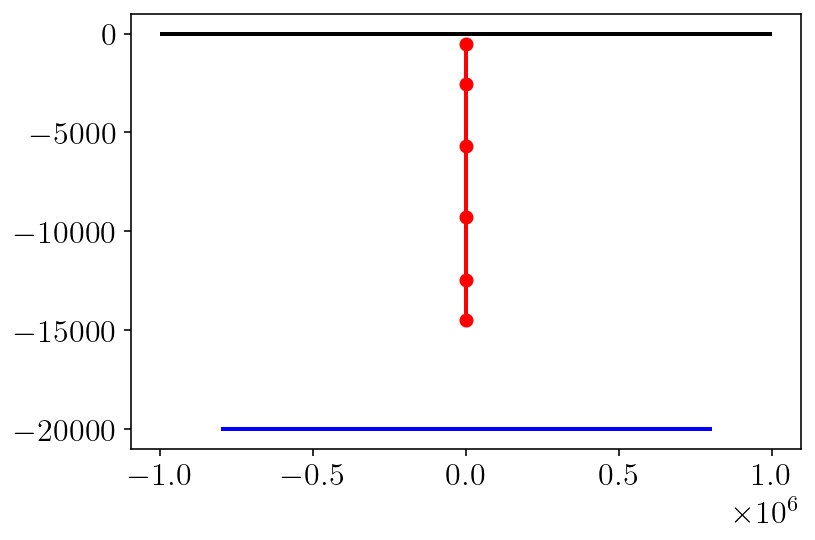

In [5]:
plt.plot(fault.pts[:,0], fault.pts[:,1], 'r-o')
plt.plot(free.pts[:,0], free.pts[:, 1], 'k-')
plt.plot(VB.pts[:,0], VB.pts[:, 1], 'b-')
plt.show()

And we'll compare against a series analytical solution originally from Nur and Mavko 1974. This can be derived from the elastic-viscoelastic correspondence principle and the Laplace transform. A good exposition in is the Segall 2008 textbook.

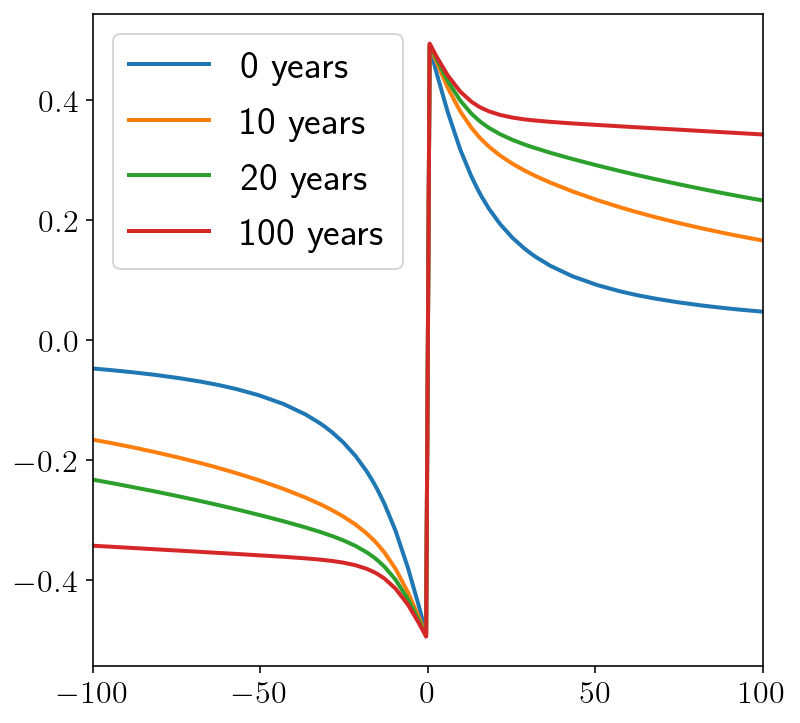

In [6]:
from math import factorial


def Fn(n, x, D, H):
    return np.arctan(2 * x * D / (x ** 2 + (2 * n * H) ** 2 - D ** 2))


def analytic_to_surface(slip, D, H, x, t):
    t_R = viscosity / shear_modulus
    C = slip / np.pi
    T1 = np.arctan(D / x)
    T2 = 0
    for n in range(1, 50):
        m_factor = 0
        for m in range(1, n + 1):
            m_factor += ((t / t_R) ** (n - m)) / factorial(n - m)
        n_factor = 1 - np.exp(-t / t_R) * m_factor
        T2 += n_factor * Fn(n, x, D, H)
    return C * (T1 + T2)


def analytic_soln(x, t):
    return analytic_to_surface(1.0, fault_bottom, visco_depth, x, t)


siay = 31556952
plt.figure(figsize=(6, 6))
for t in [0, 10.0 * siay, 20.0 * siay, 100.0 * siay]:
    plt.plot(
        free.pts[:, 0] / 1000.0,
        analytic_soln(free.pts[:, 0], t),
        label=f"{t/siay:.0f} years",
    )
plt.xlim([-100, 100])
plt.legend()
plt.show()

Next, in order to solve this problem, we'll need to more boundary integral operators. Previously, we were computing displacements or stresses given a displacement (or slip) input with the double layer and hypersingular operators respectively. Now, because of the viscoelastic boundary where the field of interest is the stress, we need two new kernels. Here, we'll introduce the single layer and adjoint double layer operators. We can think of these operators in terms of their inputs and outputs. 

* single layer: traction input, displacement output $G(\mathbf{p}, \mathbf{q})$
* double layer: displacement input, displacement output: $\frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q})$
* adjoint double layer: traction input, stress output: $\frac{\partial G}{\partial n_p}(\mathbf{p}, \mathbf{q})$
* hypersingular: displacement input, stress output: $\frac{\partial G}{\partial n_q \partial n_p}(\mathbf{p}, \mathbf{q})$

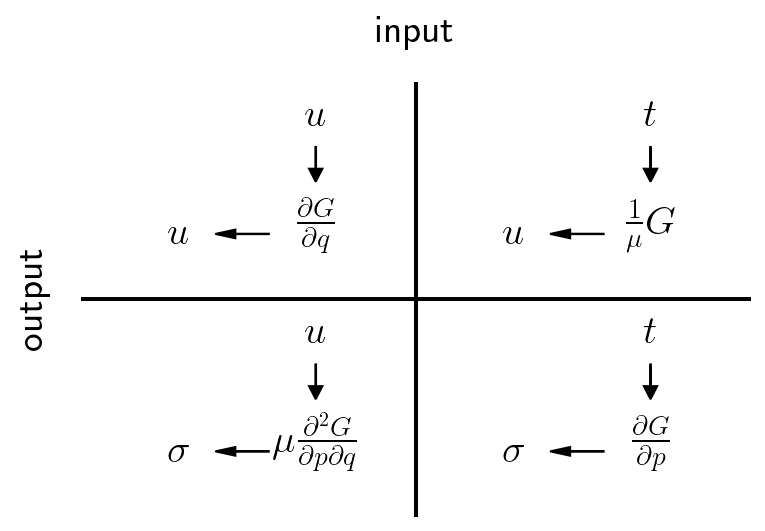

In [7]:
plt.hlines([0.5], -1, 2, color='k')
plt.vlines([0.5], -1, 2, color='k')
plt.xlim([0,1])
plt.ylim([0,1])
plt.axis('off')
plt.title('input',pad=20)

Lx=0.35
Ux=0.85
Ly=0.15
Uy = 0.65
plt.text(Lx,Uy,r'$\frac{\partial G}{\partial q}$', horizontalalignment='center')
plt.text(Ux,Uy,r'$\frac{1}{\mu}G$', horizontalalignment='center')
plt.text(Lx,Ly,r'$\mu\frac{\partial^2 G}{\partial p \partial q}$', horizontalalignment='center')
plt.text(Ux,Ly,r'$\frac{\partial G}{\partial p}$', horizontalalignment='center')
plt.text(-0.1, 0.5, 'output', rotation='vertical', verticalalignment='center')

plt.text(Lx - 0.22, Uy, '$u$',  verticalalignment='center')
plt.text(Lx - 0.22, Ly, '$\sigma$',  verticalalignment='center')
plt.text(Ux - 0.22, Uy, '$u$',  verticalalignment='center')
plt.text(Ux - 0.22, Ly, '$\sigma$',  verticalalignment='center')
plt.arrow(Lx - 0.07, Uy, -0.05, 0, head_width=0.02, color='k')
plt.arrow(Lx - 0.07, Ly, -0.05, 0, head_width=0.02, color='k')
plt.arrow(Ux - 0.07, Ly, -0.05, 0, head_width=0.02, color='k')
plt.arrow(Ux - 0.07, Uy, -0.05, 0, head_width=0.02, color='k')

plt.text(Lx, Uy + 0.25, '$u$', horizontalalignment='center')
plt.text(Lx, Ly + 0.25, '$u$', horizontalalignment='center')
plt.text(Ux, Uy + 0.25, '$t$', horizontalalignment='center')
plt.text(Ux, Ly + 0.25, '$t$', horizontalalignment='center')
plt.arrow(Lx, Uy + 0.20, 0, -0.05, head_width=0.02, color='k')
plt.arrow(Lx, Ly + 0.20, 0, -0.05, head_width=0.02, color='k')
plt.arrow(Ux, Ly + 0.20, 0, -0.05, head_width=0.02, color='k')
plt.arrow(Ux, Uy + 0.20, 0, -0.05, head_width=0.02, color='k')
plt.show()


There are two boundary integral equations that we need to compute the terms of:
1. The equation to solve for free surface displacement given the fault slip and the traction integral $S(q)$. This was derived above from the Maxwell viscoelastic equations combined with Somigliana's identity.

\begin{equation}
u(\mathbf{p}) + \int_{H} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) u(\mathbf{q}) d\mathbf{q} = -\int_{F} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) s(\mathbf{q}) d\mathbf{q} - \frac{1}{\mu}\int_{V} G(\mathbf{p}, \mathbf{q}) S(\mathbf{q}) d\mathbf{q}
\end{equation}

I'll note these terms as `{src_name}_to_free_disp`. We'll construct the inverted left hand side matrix in `free_disp_solve_mat_inv`. 

In [9]:
singularities = np.array([
    [-surf_half_L, 0],
    [surf_half_L, 0],
    [-visco_half_L, -visco_depth],
    [visco_half_L, -visco_depth],
    [0, 0],
    [0, -fault_bottom]
])

(
    free_disp_to_free_disp,
    fault_slip_to_free_disp
), report = integrate_term(
    double_layer, free.pts, free, fault, singularities=singularities, return_report=True
)
free_disp_to_free_disp = free_disp_to_free_disp[:,0,:,0]
fault_slip_to_free_disp = fault_slip_to_free_disp[:,0,:,0]
VB_S_to_free_disp, report = integrate_term(single_layer, free.pts, VB, tol=1e-10, singularities=singularities, return_report=True)
VB_S_to_free_disp = (1.0 / shear_modulus) * VB_S_to_free_disp[:,0,:,0]

free_disp_solve_mat = np.eye(free_disp_to_free_disp.shape[0]) + free_disp_to_free_disp
free_disp_solve_mat_inv = np.linalg.inv(free_disp_solve_mat)
slip = np.ones(fault.n_pts)

2. The equation to solve for the stress on the viscoelastic boundary surface. This is derived by simply taking a derivative with respect to the observation point locations and then applying the constitutive relationship. The terms here will be named `{src_name}_to_VB_stress` to indicate the input and output of the operator.

\begin{equation}
\vec{\sigma}(\mathbf{p}) = -\mu\int_{H} \frac{\partial G}{\partial n_q \partial n_p}(\mathbf{p}, \mathbf{q}) u(\mathbf{q}) d\mathbf{q} -\mu\int_{F} \frac{\partial G}{\partial n_q \partial n_p}(\mathbf{p}, \mathbf{q}) s(\mathbf{q}) d\mathbf{q} - \int_{V} \frac{\partial G}{\partial n_p} S(\mathbf{q})  d\mathbf{q}
\end{equation}

In [10]:
free_disp_to_VB_stress, fault_slip_to_VB_stress = integrate_term(
    hypersingular, VB.pts, free, fault, tol=1e-10, singularities=singularities
)
free_disp_to_VB_syz = shear_modulus * free_disp_to_VB_stress[:,1,:,0]
fault_slip_to_VB_syz = shear_modulus * fault_slip_to_VB_stress[:,1,:,0]
VB_S_to_VB_stress = integrate_term(adjoint_double_layer, VB.pts, VB, tol=1e-10, singularities=singularities)
VB_S_to_VB_syz = VB_S_to_VB_stress[:,1,:,0]

To step through time, we follow the simple procedure laid out in the introduction:

1. Solve for displacement on the free surface given the traction integral, $S^n$, and the slip, $s$. This involves using the first displacement integral equation described above.
2. Compute $\frac{\partial S(\mathbf{q})}{\partial t} = \sigma_y(\mathbf{q})$. This involves using the second traction integral equation above.
3. Integrate in time to obtain $S^{n+1}$.
4. Repeat for the next time step.

In [14]:
# The slip does not change so these two integral terms can remain
# outside the time stepping loop.
syz_fault = fault_slip_to_VB_syz.dot(slip)
rhs_slip = -fault_slip_to_free_disp.dot(slip)


# We'll integrate for 100 years of time in steps of 0.01 years. 
# siay is "seconds in a year".
n_steps = 10001
dt = 0.01 * siay
t = 0

# In the mathematical formulation, `traction_integral` was called "S(q)". 
traction_integral = np.zeros(VB.n_pts)

t_history = []
disp_history = []
S_history = []
for i in range(n_steps):
    # Step 1) Solve for free surface displacement. 
    # The linear system here looks like:
    # (I+A)*u = B*slip + C*traction_integral
    #
    # Glossary:
    # free_disp_solve_mat_inv = (I+A)^{-1}
    # rhs_slip = B*slip (pre-computed because slip isn't changing)
    # VB_S_to_free_disp = C
    rhs = rhs_slip - VB_S_to_free_disp.dot(traction_integral)
    free_disp = free_disp_solve_mat_inv.dot(rhs)

    # Store the current system state.
    t_history.append(t)
    disp_history.append(free_disp)
    S_history.append(traction_integral.copy())

    # Step 2): Calculate viscoelastic boundary traction and then d[S]/dt
    # The linear system here looks like:
    # I*syz = A*u + B*slip + C*S
    # 
    # Glossary:
    # `syz_free` = A*u
    # `syz_fault` = B*slip (pre-computed because slip isn't changing)
    # `syz_VB` = C*S
    syz_free = free_disp_to_VB_syz.dot(free_disp)
    syz_VB = VB_S_to_VB_syz.dot(traction_integral)

    # evaluating the boundary stress requires a multiple of two due to 
    # some esoteric boundary jump term issues
    syz = 2 * (syz_free + syz_fault + syz_VB)
    dSdt = (shear_modulus / viscosity) * syz

    # Step 3): Update S, simple forward Euler time step.
    traction_integral += dSdt * dt
    t += dt
t_history = np.array(t_history)

In [15]:
# Numerically differentiate to obtain velocities.
velocity = siay * np.diff(np.array(disp_history), axis=0) / np.diff(t_history)[:, None]

## Comparison against the analytic solution.

The first and second plots below show the numerical solution for displacement against the analytic solution. We can see that the error rises over time. I dug into the source of this error and its completely dominated by the error from truncating the infinite surfaces in the analytic problem into finite surfaces here. Compared to the purely elastic setting, the very farfield has a larger influence on the solution. Even so, we're getting five digits of accuracy for small $t$ and about three digits for larger $t$.

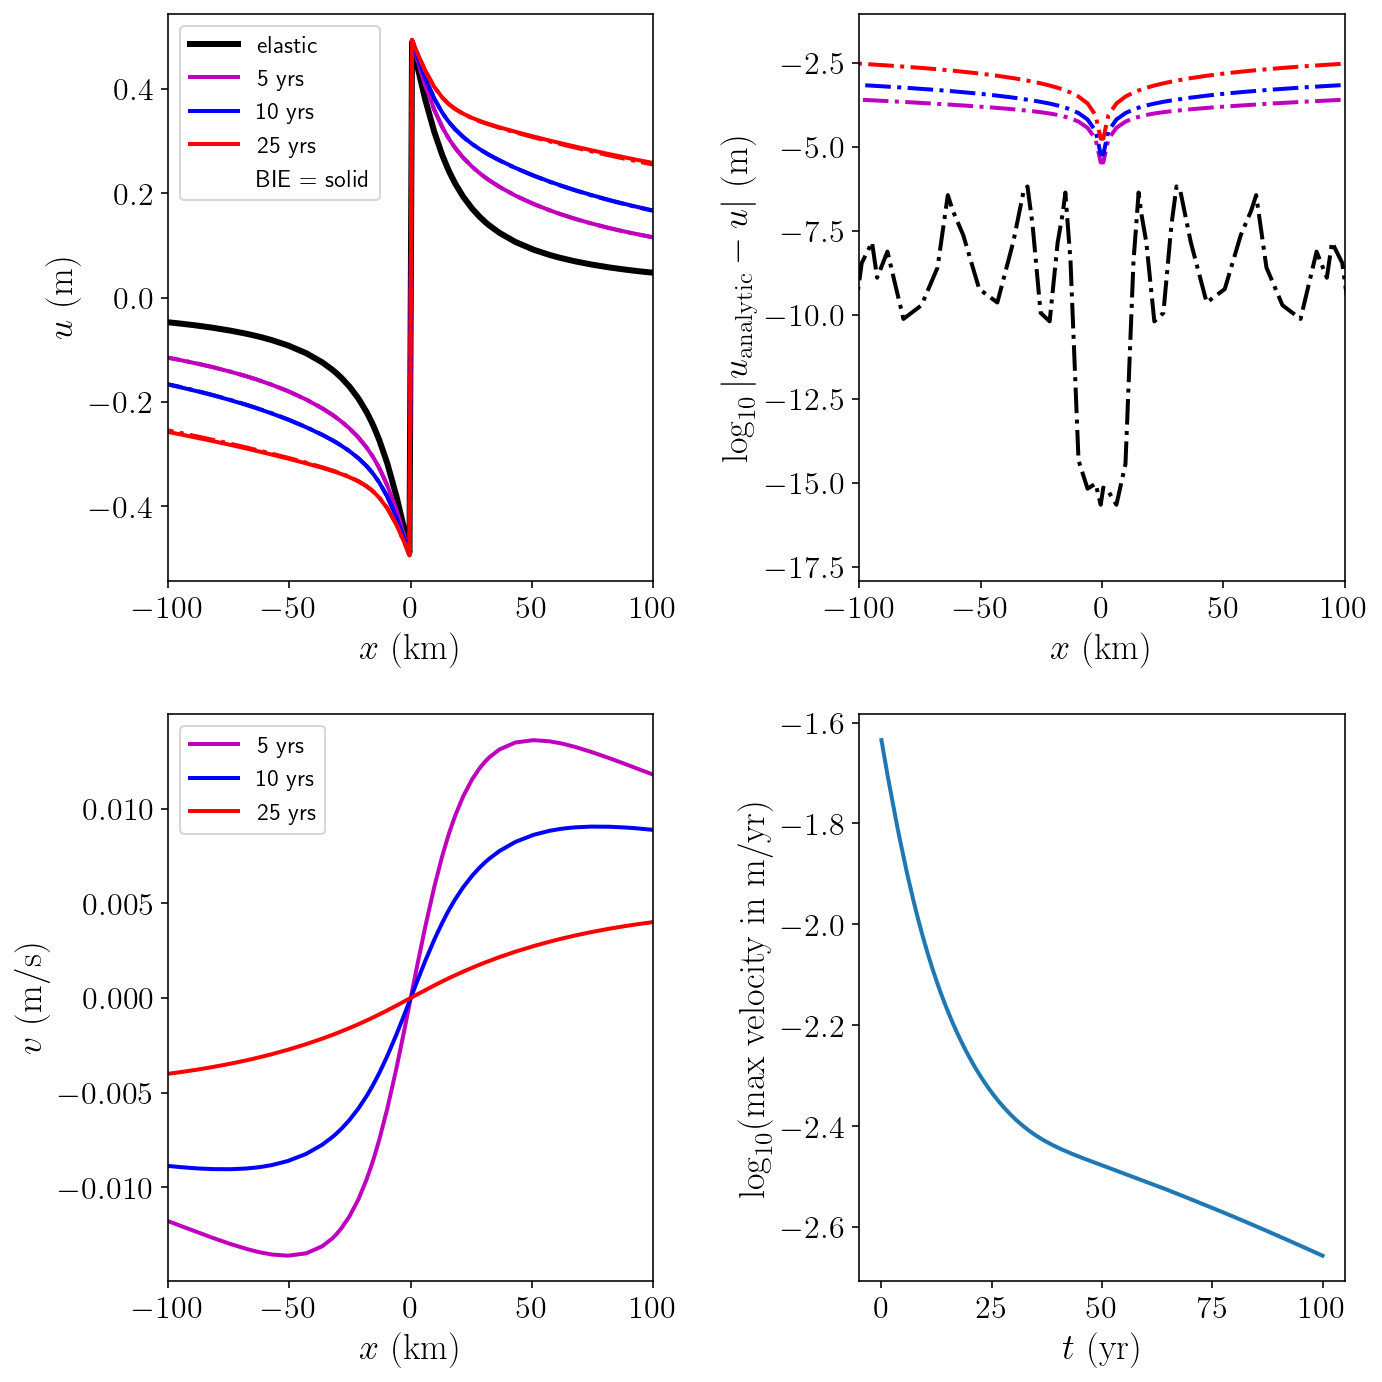

In [16]:
plt.figure(figsize=(10, 10))
X = free.pts[:, 0] / 1000

plt.subplot(2, 2, 1)
plt.plot(X, disp_history[0], "k-", linewidth=3, label="elastic")
steps_to_plt = [("m", 500, 5), ("b", 1000, 10), ("r", 2500, 25)]
for color, i, yr in steps_to_plt:
    plt.plot(X, disp_history[i], color + "-", label=str(yr) + " yrs")
    plt.plot(X, analytic_soln(free.pts[:, 0], t_history[i]), color + "-.")
plt.plot([], [], " ", label="BIE = solid")
plt.xlim([-100, 100])
plt.xlabel(r"$x ~ \mathrm{(km)}$")
plt.ylabel(r"$u ~ \mathrm{(m)}$")
plt.legend(loc="upper left", fontsize=12)

plt.subplot(2, 2, 2)
for color, i, yr in [("k", 0, 0)] + steps_to_plt:
    analytic = analytic_soln(free.pts[:, 0], t_history[i])
    numerical = disp_history[i]
    diff = analytic - numerical
    plt.plot(X, np.log10(np.abs(diff)), color + "-.")
plt.xlim([-100, 100])
plt.xlabel(r"$x ~ \mathrm{(km)}$")
plt.ylabel(r"$\log_{10}{|u_{\textrm{analytic}} - u|} ~ \mathrm{(m)}$")

plt.subplot(2, 2, 3)
for color, i, yr in steps_to_plt:
    plt.plot(X, velocity[i], color + "-", label=str(yr) + " yrs")
plt.xlim([-100, 100])
plt.xlabel(r"$x ~ \mathrm{(km)}$")
plt.ylabel(r"$v ~ \mathrm{(m/s)}$")
plt.legend(fontsize=12)

plt.subplot(2, 2, 4)
plt.plot(t_history[1:] / siay, np.log10(np.max(np.abs(velocity), axis=1)))
plt.xlabel(r"$t ~ (\textrm{yr})$")
plt.ylabel(r"$\log_{10}(\textrm{max velocity in m/yr})$")

plt.tight_layout()
plt.show()

## Interior evaluation and visualization

Let's choose a few points in time and look at the whole displacement and stress fields in the domain!

I'll choose a grid of points focused on the area around the fault. That's the most interesting area!

In [17]:
from tectosaur2.mesh import pts_grid
nobs = 200
zoomx = [-15000, 15000]
zoomy = [-31000, -1000]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obs_pts = pts_grid(xs, ys)
obsx = obs_pts[:, 0].reshape((nobs, nobs))
obsy = obs_pts[:, 1].reshape((nobs, nobs))

These integral terms come from the same pair of integral equations that used above to solve for displacement and the viscoelastic boundary traction. However, this time we input our grid of observation points instead and evaluate in the interior.

I've also added a few handy functions that will make our plotting adventures easier.

In [18]:
free_disp_to_volume_disp, fault_slip_to_volume_disp = integrate_term(
    double_layer, obs_pts, free, fault, tol=1e-10, singularities=singularities
)
VB_S_to_volume_disp = integrate_term(
    single_layer, obs_pts, VB, tol=1e-10, singularities=singularities
)
VB_S_to_volume_disp /= shear_modulus

free_disp_to_volume_stress, fault_slip_to_volume_stress = integrate_term(
    hypersingular, obs_pts, free, fault, tol=1e-10, singularities=singularities
)
free_disp_to_volume_stress *= shear_modulus
fault_slip_to_volume_stress *= shear_modulus
VB_S_to_volume_stress = integrate_term(
    adjoint_double_layer, obs_pts, VB, tol=1e-10, singularities=singularities
)

In [21]:
def get_volumetric_disp(free_disp, slip, stress_integral):
    disp_free = free_disp_to_volume_disp[:,0,:,0].dot(free_disp)
    disp_fault = fault_slip_to_volume_disp[:,0,:,0].dot(slip)
    disp_VB = VB_S_to_volume_disp[:,0,:,0].dot(stress_integral)
    return (-disp_free - disp_fault + disp_VB).reshape(obsx.shape)


def get_volumetric_stress(free_disp, slip, stress_integral):
    stress_free = free_disp_to_volume_stress[:,:,:,0].dot(free_disp)
    stress_fault = fault_slip_to_volume_stress[:,:,:,0].dot(slip)
    stress_VB = VB_S_to_volume_stress[:,:,:,0].dot(stress_integral)

    return (-stress_free - stress_fault + stress_VB).reshape((obsx.shape[0], obsx.shape[1], 2))


def simple_plot(field, levels):
    n_dims = field.shape[2]
    for d in range(field.shape[2]):
        cntf = plt.contourf(
            obsx/1000.0, obsy/1000.0, field[:, :, d], levels=levels, extend="both", cmap="RdBu_r"
        )
        plt.contour(
            obsx/1000.0,
            obsy/1000.0,
            field[:, :, d],
            colors="k",
            linestyles="-",
            linewidths=0.5,
            levels=levels,
            extend="both",
        )
        plt.plot(free.pts[:, 0]/1000.0, free.pts[:, 1]/1000.0, "k-", linewidth=1.5)
        plt.plot(fault.pts[:, 0]/1000.0, fault.pts[:, 1]/1000.0, "k-", linewidth=1.5)
        cbar = plt.colorbar(cntf)
        plt.axis('scaled')
        plt.xlim([zoomx[0]/1000.0, zoomx[1]/1000])
        plt.ylim([zoomy[0]/1000.0, zoomy[1]/1000])
        plt.xticks([])
        plt.yticks([])


Great, now we get to make some really fun figures! I'm going to plot the state of the system at four different points in time: 0 years (the initial conditions), 1 year, 5 years and 20 years. At each point in time, there will be four columns and three rows of figures. The first row will show displacements, the second row will show $\sigma_{xz}$ and the third row will show $\sigma_{yz}$. The columns are showing subcomponents of the solution:
* The first column shows the displacement and stress induced by the surface displacement field *alone*. To be precise, we are plotting the integral $-\int_{H} \frac{\partial G(p, q)}{\partial p} u(q) dq$
* The second column shows the displacement and stress induced by the fault dislocation *alone: $-\int_{F} \frac{\partial G(p, q)}{\partial p} s(q) dq$
* The third column shows the displacement and stress induced by the viscoelastic boundary traction: $-\int_{V} G(p, q) S(q) dq$
* The fourth column shows the total solution which is the sum of the first three columns.

There are a bunch of interesting features to note:
* In the initial conditions, the viscoelastic boundary terms are all zero. This makes sense!
* The fault slip column is constant in time because the slip is not changing.
* As the surface displacement spreads outwards from the fault, the displacements increase deeper and farther from the fault.
* In year 5, in the total solution column, a small kink in the displacement field contours is visible at the viscoelastic boundary. This is to be expected from the jump in stress. A stress jump will lead to a jump in strain which is equivalent to a change in displacement derivative, causing the kink.
* By year 20, the viscous layer has mostly relaxed in the nearfield. The displacement and stress are indistinguishable from zero in the plots.


/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_59074/842346407.py:22: UserWarning: No contour levels were found within the data range.
  plt.contour(
/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_59074/842346407.py:22: UserWarning: No contour levels were found within the data range.
  plt.contour(
/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_59074/842346407.py:22: UserWarning: No contour levels were found within the data range.
  plt.contour(


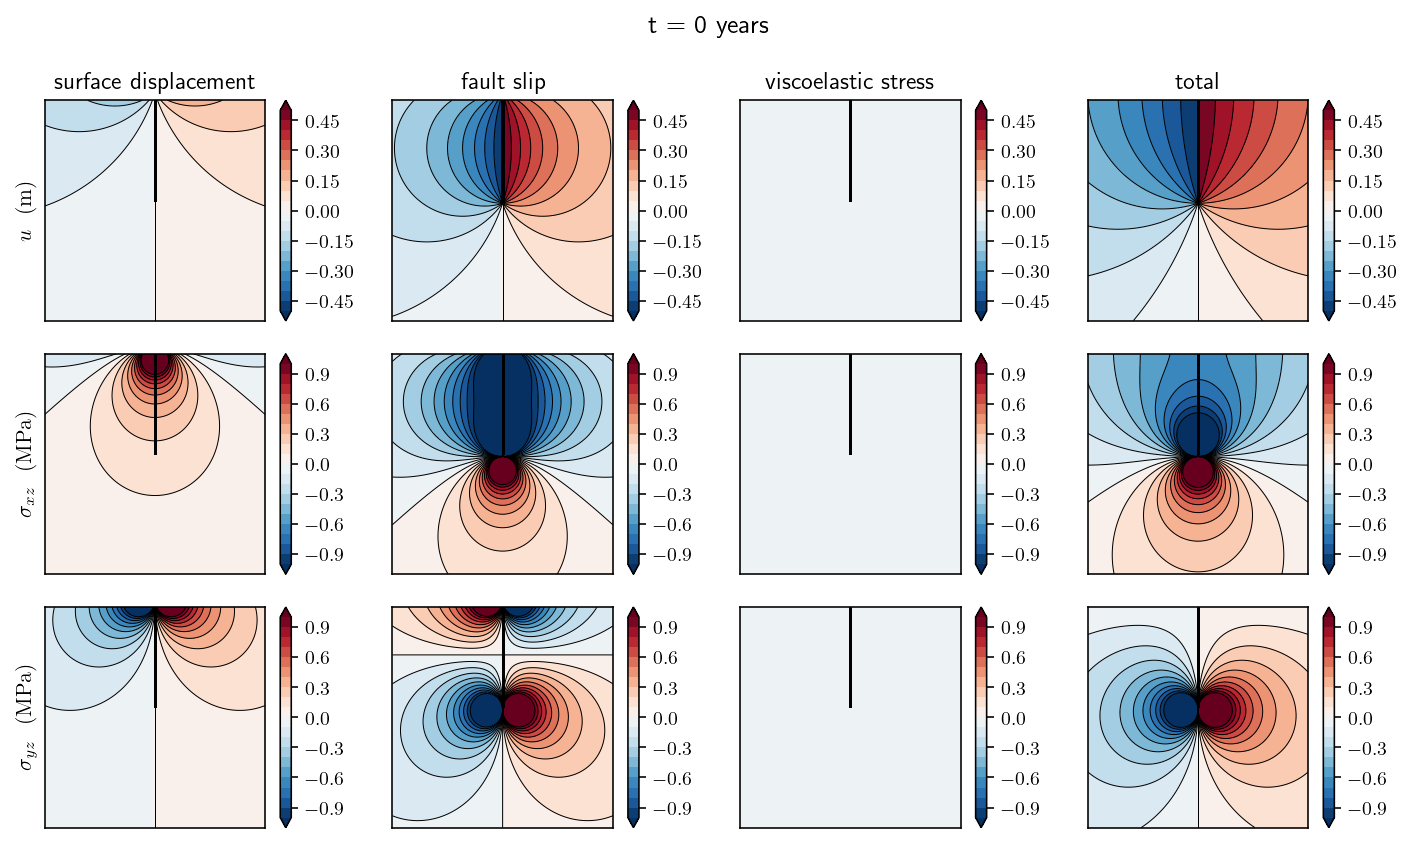

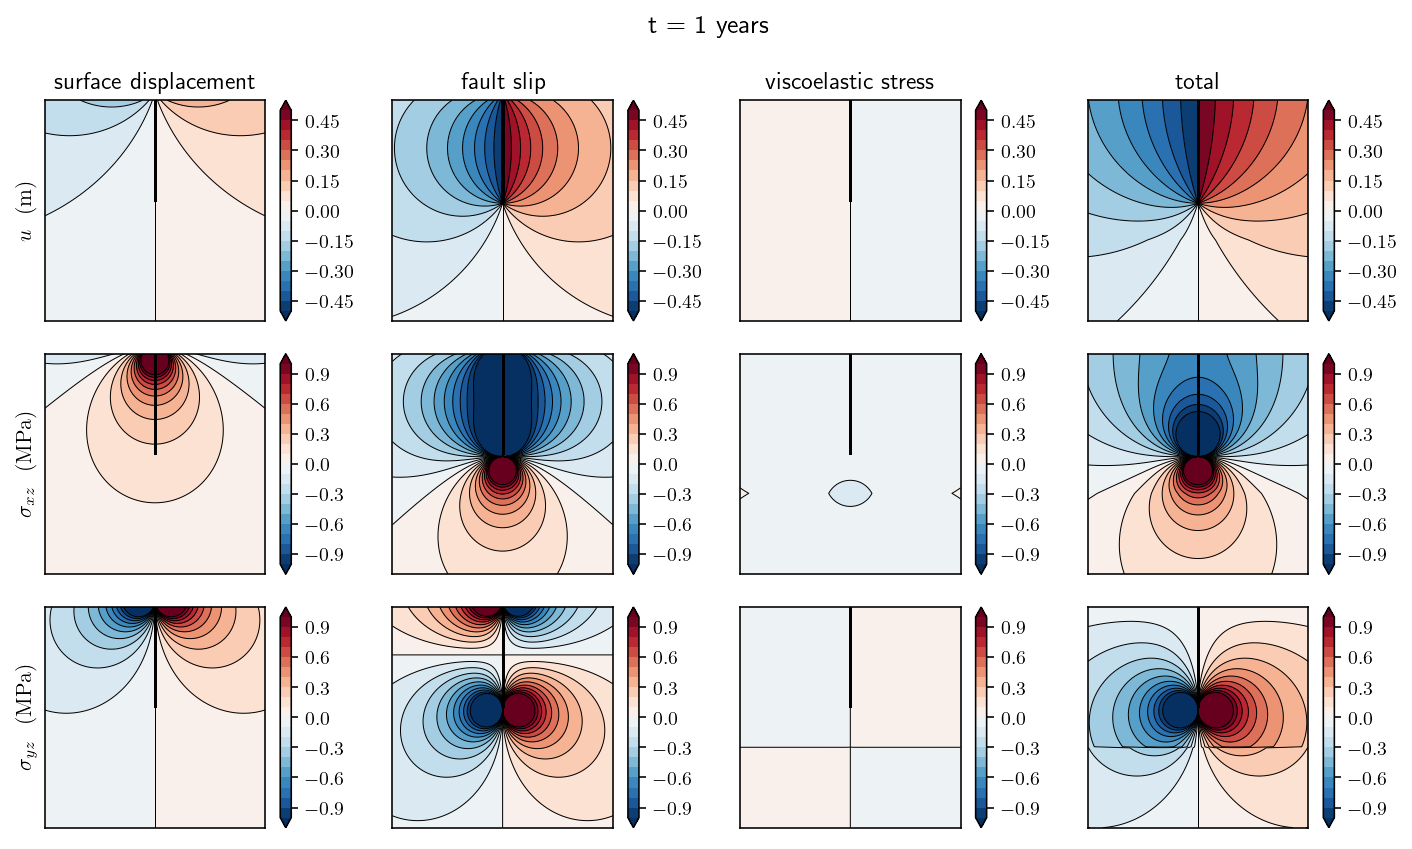

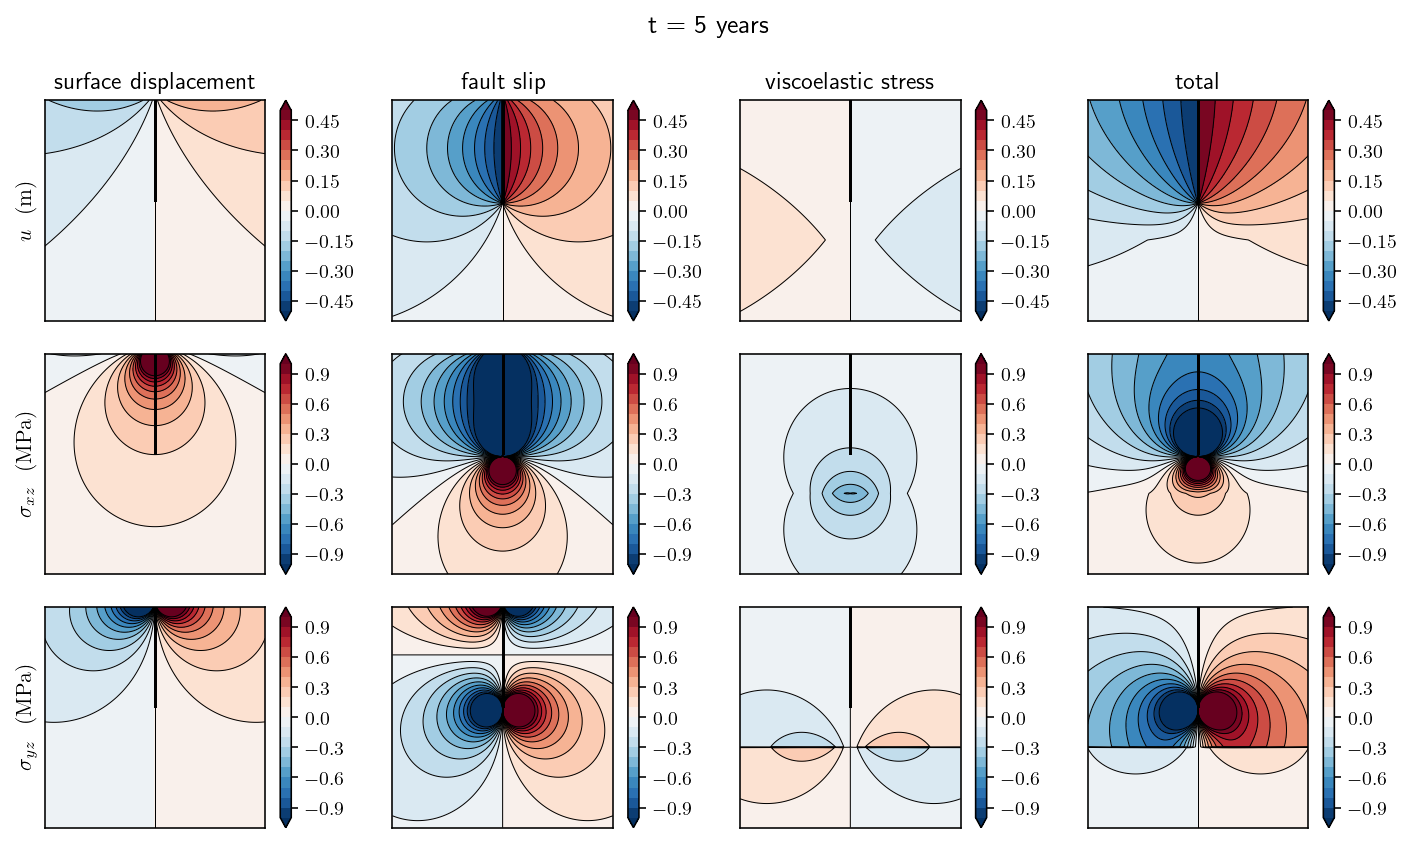

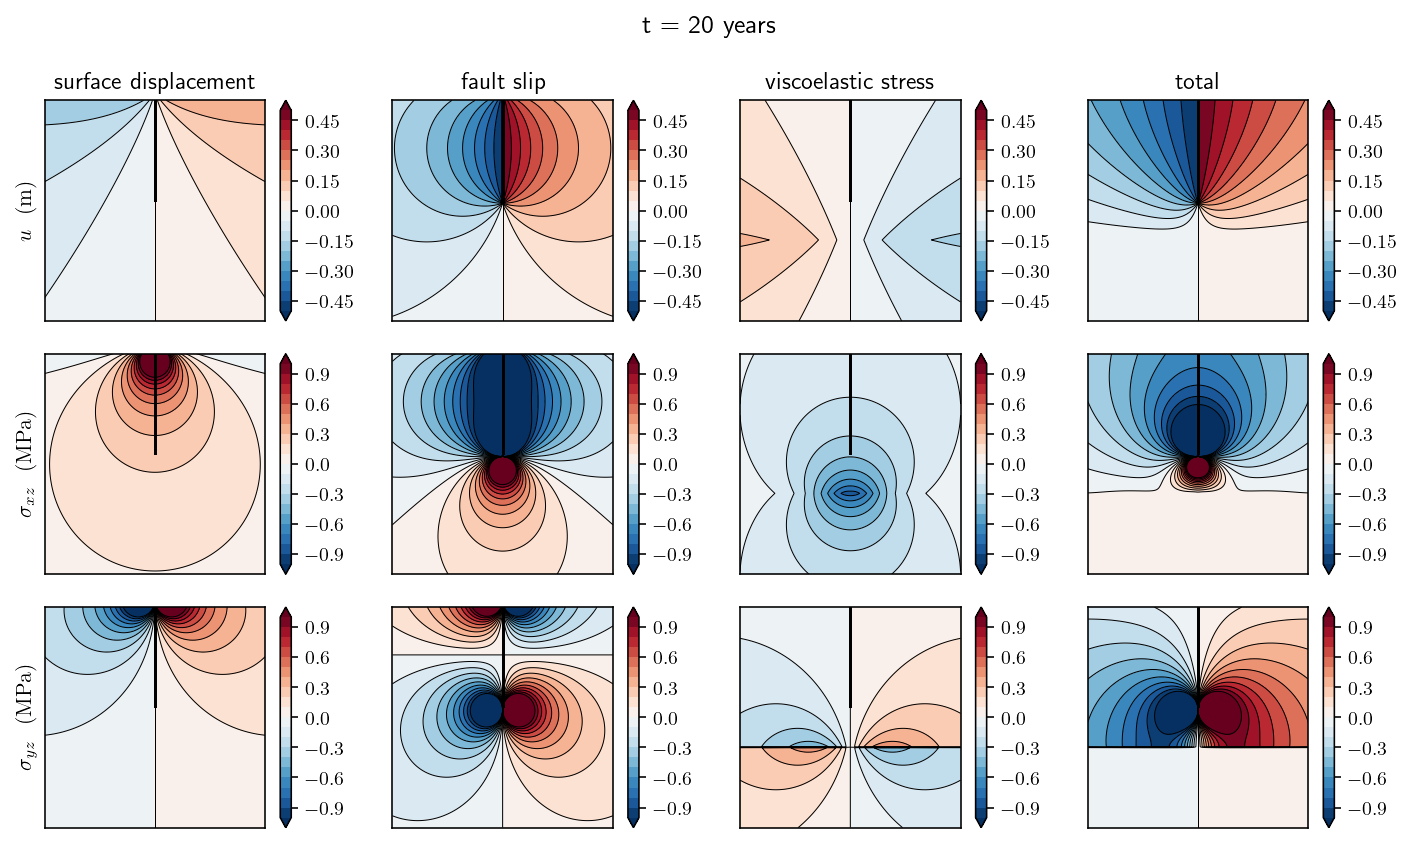

In [22]:
from tectosaur2.nb_config import scale_features
scale_features(0.6)
for t_idx in [0, 100, 500, 2000]:
    fig = plt.figure(figsize=(10,6))
    plt.suptitle(f't = {t_history[t_idx]/siay:.0f} years')
    for i, terms in enumerate([(1, 0, 0), (0, 1, 0), (0, 0, 1), (1,1,1)]):
    # for i, terms in enumerate([(1, 0, 0)]):#, (0, 1, 0), (0, 0, 1), (1,1,1)]):
        disp = get_volumetric_disp(
            terms[0] * disp_history[t_idx], terms[1] * slip, terms[2] * S_history[t_idx]
        )
        plt.subplot(3,4,1+i)
        plt.title(['surface displacement', 'fault slip', 'viscoelastic stress', 'total'][i])
        simple_plot(disp[:, :, None], np.linspace(-0.5, 0.5, 21))
        if i == 0:
            plt.ylabel('$u ~~ \mathrm{(m)}$')
        

        stress = get_volumetric_stress(
            terms[0] * disp_history[t_idx], terms[1] * slip, terms[2] * S_history[t_idx]
        )
        levels = np.linspace(-1, 1, 21)
        plt.subplot(3,4,5+i)
        simple_plot(stress[:,:,0,None]/1e6, levels)
        if i == 0:
            plt.ylabel('$\sigma_{xz} ~~ \mathrm{(MPa)}$')
        plt.subplot(3,4,9+i)
        simple_plot(stress[:,:,1,None]/1e6, levels)
        if i == 0:
            plt.ylabel('$\sigma_{yz} ~~ \mathrm{(MPa)}$')
    plt.tight_layout()
    plt.show()